# Hospital Project

## Problem Statement

The goal of this mini project is to answer a few questions regarding administrative issues in this hospital.

1. Are there differences in revenue collection based on `Financial Classes`? What can be done to increase revenue for the hospital based on these differences?

2. Which doctor type generates the most revenue (Medication and Consultation) per consultation?

3. Determine busy periods that require more manpower and make any improvements or suggestions with reference to insights gathered from the analysis.

After answering required questions, cleaned data will be exported for visualisation in Tableau

The flow of this project is as follows:

### 1. Data Cleaning and Exploratory Data Analysis
### 2. Answering required questions
### 3. Tableau Visualisation



Firstly we move the raw data downloaded to the appropriate directory

In [1]:
# import shutil

# # Move file to the correct location
# def move_file(source, destination):
#     try:
#         shutil.move(source, destination)
#         print(f"File '{source}' moved successfully to '{destination}'.")
#     except FileNotFoundError:
#         print(f"Error: File '{source}' not found.")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# source = r'/Users/jaden/Downloads/hospital_data_sampleee.xlsx'
# destination = r'/Users/jaden/Desktop/Coding/portfolio_projects/hospital'

# move_file(source, destination)

Here we import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_excel(r'hospital_data_sampleee.xlsx')
df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Patient Type,Entry Time,Post-Consultation Time,Completion Time,Patient ID
0,2019-11-04,1183.22,10,20.17,ANCHOR,HMO,OUTPATIENT,08:35:45,09:17:54,09:29:46,C10001
1,2019-11-06,738.48,$-,15,ANCHOR,INSURANCE,OUTPATIENT,19:19:16,21:02:36,21:24:07,C10002
2,2019-11-02,660,$-,21.17,ANCHOR,HMO,OUTPATIENT,10:46:52,11:56:25,12:06:28,C10003
3,2019-11-06,600,$-,$-,ANCHOR,MEDICARE,OUTPATIENT,09:38:34,10:55:50,10:58:02,C10004
4,2019-11-01,591.6,$-,12,ANCHOR,INSURANCE,OUTPATIENT,11:16:21,12:06:49,12:06:54,C10005


Each row represents a patient visit.

The definition of each feature is as follows:

`Date` : The day patient visited

`Medication Revenue` : Revenue earned from medication dispensed to that patient

`Lab Cost` : Lab cost paid by the patient

`Consultation Revenue` : Revenue earned from doctor consultation 

`Doctor Type` : The type of doctor who treated the patient

`Financial Class` : Patient financial Class

`Patient Type` : Type of patient

`Entry Time` : Patient's entry time into hospital

`Post-Consultation Time` : Time at which patient enters consultation room

`Completion Time` : Time at which patient exits the hospital

`Patient ID` : The unique identification given to each patient

Given these definitions, I will be renaming `Post-Consultation Time` to `Consultation Start Time` for better clarity.

In [3]:
df.rename(columns={'Post-Consultation Time': 'Consultation Start Time'}, inplace=True)
df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Patient Type,Entry Time,Consultation Start Time,Completion Time,Patient ID
0,2019-11-04,1183.22,10,20.17,ANCHOR,HMO,OUTPATIENT,08:35:45,09:17:54,09:29:46,C10001
1,2019-11-06,738.48,$-,15,ANCHOR,INSURANCE,OUTPATIENT,19:19:16,21:02:36,21:24:07,C10002
2,2019-11-02,660,$-,21.17,ANCHOR,HMO,OUTPATIENT,10:46:52,11:56:25,12:06:28,C10003
3,2019-11-06,600,$-,$-,ANCHOR,MEDICARE,OUTPATIENT,09:38:34,10:55:50,10:58:02,C10004
4,2019-11-01,591.6,$-,12,ANCHOR,INSURANCE,OUTPATIENT,11:16:21,12:06:49,12:06:54,C10005


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     29998 non-null  datetime64[ns]
 1    Medication Revenue      29998 non-null  object        
 2     Lab Cost               29998 non-null  object        
 3    Consultation Revenue    29998 non-null  object        
 4   Doctor Type              29998 non-null  object        
 5   Financial Class          29998 non-null  object        
 6   Patient Type             29998 non-null  object        
 7   Entry Time               29998 non-null  object        
 8   Consultation Start Time  29998 non-null  object        
 9   Completion Time          29998 non-null  object        
 10  Patient ID               29998 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 2.5+ MB


In [5]:
# Check for missing values
print(df.isnull().sum())
# Check for duplicates
print(f'\nDuplicates: {df.duplicated().sum()}')

Date                       0
 Medication Revenue        0
  Lab Cost                 0
 Consultation Revenue      0
Doctor Type                0
Financial Class            0
Patient Type               0
Entry Time                 0
Consultation Start Time    0
Completion Time            0
Patient ID                 0
dtype: int64

Duplicates: 0


There appears to be no null values in the data. However, whitespaces are noted in some column names so we will get rid of them.

In [6]:
# Remove leading and trailing whitespace from column names
df.columns = df.columns.str.strip()
df.columns

Index(['Date', 'Medication Revenue', 'Lab Cost', 'Consultation Revenue',
       'Doctor Type', 'Financial Class', 'Patient Type', 'Entry Time',
       'Consultation Start Time', 'Completion Time', 'Patient ID'],
      dtype='object')

Next, check if each row represents a unique patient or if patients revisited

In [7]:
df['Patient ID'].nunique()

29998

Since each row does in fact mean a unique patient, we can make `Patient ID` the index of our dataframe.

In [8]:
df.set_index('Patient ID', inplace=True)
df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Patient Type,Entry Time,Consultation Start Time,Completion Time
Patient ID,,,,,,,,,,
C10001,2019-11-04,1183.22,10,20.17,ANCHOR,HMO,OUTPATIENT,08:35:45,09:17:54,09:29:46
C10002,2019-11-06,738.48,$-,15,ANCHOR,INSURANCE,OUTPATIENT,19:19:16,21:02:36,21:24:07
C10003,2019-11-02,660,$-,21.17,ANCHOR,HMO,OUTPATIENT,10:46:52,11:56:25,12:06:28
C10004,2019-11-06,600,$-,$-,ANCHOR,MEDICARE,OUTPATIENT,09:38:34,10:55:50,10:58:02
C10005,2019-11-01,591.6,$-,12,ANCHOR,INSURANCE,OUTPATIENT,11:16:21,12:06:49,12:06:54


Finding unique values of categorical variables

In [9]:
# Find unique values of categorical variables
cat_cols = ['Doctor Type', 'Financial Class', 'Patient Type']
for col in cat_cols:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'Doctor Type': ['ANCHOR' 'LOCUM' 'FLOATING']
Unique values in 'Financial Class': ['HMO' 'INSURANCE' 'MEDICARE' 'CORPORATE' 'PRIVATE']
Unique values in 'Patient Type': ['OUTPATIENT']


Since there is only one `Patient Type`, we will remove it from consideration in our analysis.

In [10]:
df.drop(columns=['Patient Type'], inplace=True)
df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Entry Time,Consultation Start Time,Completion Time
Patient ID,,,,,,,,,
C10001,2019-11-04,1183.22,10,20.17,ANCHOR,HMO,08:35:45,09:17:54,09:29:46
C10002,2019-11-06,738.48,$-,15,ANCHOR,INSURANCE,19:19:16,21:02:36,21:24:07
C10003,2019-11-02,660,$-,21.17,ANCHOR,HMO,10:46:52,11:56:25,12:06:28
C10004,2019-11-06,600,$-,$-,ANCHOR,MEDICARE,09:38:34,10:55:50,10:58:02
C10005,2019-11-01,591.6,$-,12,ANCHOR,INSURANCE,11:16:21,12:06:49,12:06:54


The revenue and cost features have '$-' in some rows to denote no amount was incurred by the patient. To ensure data integrity I will replace these values with 0, and change the data type to float.

In [11]:
# Convert `Medication Revenue`, `Lab Cost`, `Consultation Revenue` to numeric, forcing errors to 0
num_cols = ['Medication Revenue', 'Lab Cost', 'Consultation Revenue']

for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

print(df[num_cols].head())
print()
print(df[num_cols].dtypes)

            Medication Revenue  Lab Cost  Consultation Revenue
Patient ID                                                    
C10001                 1183.22      10.0                 20.17
C10002                  738.48       0.0                 15.00
C10003                  660.00       0.0                 21.17
C10004                  600.00       0.0                  0.00
C10005                  591.60       0.0                 12.00

Medication Revenue      float64
Lab Cost                float64
Consultation Revenue    float64
dtype: object


Now, assuming that all visits happen on the same day (no overnight stays / visits that go past 12am the next day), I will convert values to datetime values.

In [12]:
# Convert time columns to datetime
cols_to_convert = ['Entry Time', 'Consultation Start Time', 'Completion Time']

for col in cols_to_convert:
    df[col] = pd.to_timedelta(df[col].astype(str))

print(df[cols_to_convert].head())
print()
print(df[cols_to_convert].dtypes)

                Entry Time Consultation Start Time Completion Time
Patient ID                                                        
C10001     0 days 08:35:45         0 days 09:17:54 0 days 09:29:46
C10002     0 days 19:19:16         0 days 21:02:36 0 days 21:24:07
C10003     0 days 10:46:52         0 days 11:56:25 0 days 12:06:28
C10004     0 days 09:38:34         0 days 10:55:50 0 days 10:58:02
C10005     0 days 11:16:21         0 days 12:06:49 0 days 12:06:54

Entry Time                 timedelta64[ns]
Consultation Start Time    timedelta64[ns]
Completion Time            timedelta64[ns]
dtype: object


In [13]:
df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Entry Time,Consultation Start Time,Completion Time
Patient ID,,,,,,,,,
C10001,2019-11-04,1183.22,10.0,20.17,ANCHOR,HMO,0 days 08:35:45,0 days 09:17:54,0 days 09:29:46
C10002,2019-11-06,738.48,0.0,15.00,ANCHOR,INSURANCE,0 days 19:19:16,0 days 21:02:36,0 days 21:24:07
C10003,2019-11-02,660.00,0.0,21.17,ANCHOR,HMO,0 days 10:46:52,0 days 11:56:25,0 days 12:06:28
C10004,2019-11-06,600.00,0.0,0.00,ANCHOR,MEDICARE,0 days 09:38:34,0 days 10:55:50,0 days 10:58:02
C10005,2019-11-01,591.60,0.0,12.00,ANCHOR,INSURANCE,0 days 11:16:21,0 days 12:06:49,0 days 12:06:54


In [14]:
df.describe()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Entry Time,Consultation Start Time,Completion Time
count,29998,29998.000000,29998.000000,29998.000000,29998,29998,29998
mean,2019-11-07 00:06:20.185345536,20.636710,2.229156,15.266311,0 days 13:28:58.862357490,0 days 14:07:53.724248283,0 days 14:12:48.321554770
min,2019-11-01 00:00:00,0.000000,0.000000,0.000000,0 days 07:53:25,0 days 08:07:41,0 days 08:07:57
25%,2019-11-04 00:00:00,0.000000,0.000000,10.000000,0 days 09:54:58.500000,0 days 10:43:55.250000,0 days 10:49:05.500000
50%,2019-11-07 00:00:00,13.600000,0.000000,13.000000,0 days 12:05:38.500000,0 days 12:47:44.500000,0 days 12:53:05
75%,2019-11-11 00:00:00,29.400000,0.000000,23.040000,0 days 16:36:46,0 days 17:11:38.500000,0 days 17:16:16.500000
max,2019-11-13 00:00:00,1183.220000,520.000000,120.000000,0 days 23:47:37,0 days 23:54:47,0 days 23:55:57
std,NaN,33.251048,14.690634,10.451545,0 days 04:02:53.637337419,0 days 03:58:45.685113421,0 days 03:58:22.883373346


We can now create multiple new columns describing durations at the hospital, as well as `Month` and `Date` columns for further comparison.

In [15]:
# Time spent talking to the doctor
df['Consultation Duration'] = df['Completion Time'] - df['Consultation Start Time']

# Time spent waiting for consultation with the doctor
df['Waiting Time'] = df['Consultation Start Time'] - df['Entry Time']

# Convert timedelta to minutes
df['Consultation Duration'] = df['Consultation Duration'].dt.total_seconds() / 60
df['Waiting Time'] = df['Waiting Time'].dt.total_seconds() / 60

# Total time spent in the hospital
df['Total Time'] = df['Consultation Duration'] + df['Waiting Time']

df.head()

,Date,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Entry Time,Consultation Start Time,Completion Time,Consultation Duration,Waiting Time,Total Time
Patient ID,,,,,,,,,,,,
C10001,2019-11-04,1183.22,10.0,20.17,ANCHOR,HMO,0 days 08:35:45,0 days 09:17:54,0 days 09:29:46,11.866667,42.150000,54.016667
C10002,2019-11-06,738.48,0.0,15.00,ANCHOR,INSURANCE,0 days 19:19:16,0 days 21:02:36,0 days 21:24:07,21.516667,103.333333,124.850000
C10003,2019-11-02,660.00,0.0,21.17,ANCHOR,HMO,0 days 10:46:52,0 days 11:56:25,0 days 12:06:28,10.050000,69.550000,79.600000
C10004,2019-11-06,600.00,0.0,0.00,ANCHOR,MEDICARE,0 days 09:38:34,0 days 10:55:50,0 days 10:58:02,2.200000,77.266667,79.466667
C10005,2019-11-01,591.60,0.0,12.00,ANCHOR,INSURANCE,0 days 11:16:21,0 days 12:06:49,0 days 12:06:54,0.083333,50.466667,50.550000


Sanity check for durations and removal of invalid entries

In [16]:
# Check for negative consultation durations
negative_consultation_durations = df[df['Consultation Duration'] < 0]
negative_waiting_durations = df[df['Waiting Time'] < 0]

print(f'Invalid consultation durations: {len(negative_consultation_durations)} \nInvalid waiting times: {len(negative_waiting_durations)}')

Invalid consultation durations: 389 
Invalid waiting times: 0


Since there are close to 30000 rows, removal of 389 rows is negligible.

In [17]:
# Remove rows with negative consultation durations
df = df[df['Consultation Duration'] >= 0]

(df.any() < 0).value_counts()

False    12
Name: count, dtype: int64

In [18]:
# Creating `Day Of Week` column from `Date` and changing their position to be after `Date`
df['Day'] = df['Date'].dt.day
df['Day Of Week'] = df['Date'].dt.day_name().str.slice(0, 3).str.capitalize()
df['Hours'] = df['Entry Time'].dt.components.hours
df.insert(1, 'Day Of Week', df.pop('Day Of Week'))
df.insert(2, 'Day', df.pop('Day'))
df.insert(3, 'Hours', df.pop('Hours'))

# Convert `Day`, `Day Of Week`, `Hour` to categorical types
def convert(df, col):
    for i in col:
        df[i] = df[i].astype('category')

col = ['Day', 'Day Of Week', 'Hours']
convert(df, col)

# Drop `Date` column
df.drop(columns=['Date'], inplace=True)

df.head()

,Day Of Week,Day,Hours,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Entry Time,Consultation Start Time,Completion Time,Consultation Duration,Waiting Time,Total Time
Patient ID,,,,,,,,,,,,,,
C10001,Mon,4,8,1183.22,10.0,20.17,ANCHOR,HMO,0 days 08:35:45,0 days 09:17:54,0 days 09:29:46,11.866667,42.150000,54.016667
C10002,Wed,6,19,738.48,0.0,15.00,ANCHOR,INSURANCE,0 days 19:19:16,0 days 21:02:36,0 days 21:24:07,21.516667,103.333333,124.850000
C10003,Sat,2,10,660.00,0.0,21.17,ANCHOR,HMO,0 days 10:46:52,0 days 11:56:25,0 days 12:06:28,10.050000,69.550000,79.600000
C10004,Wed,6,9,600.00,0.0,0.00,ANCHOR,MEDICARE,0 days 09:38:34,0 days 10:55:50,0 days 10:58:02,2.200000,77.266667,79.466667
C10005,Fri,1,11,591.60,0.0,12.00,ANCHOR,INSURANCE,0 days 11:16:21,0 days 12:06:49,0 days 12:06:54,0.083333,50.466667,50.550000


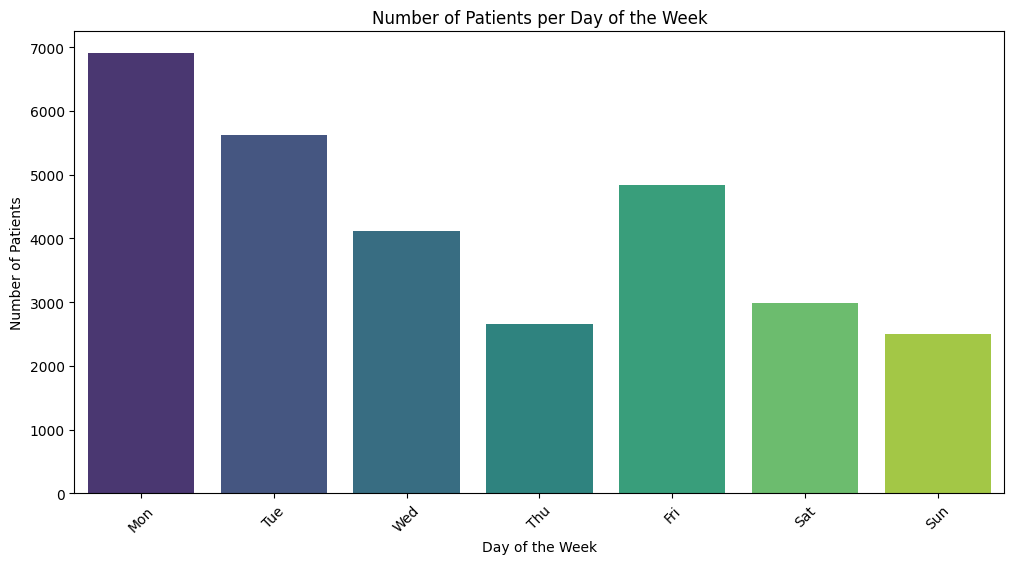

In [19]:
# Plotting the trend of patients over days of the week
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Day Of Week', order=day_order, palette='viridis')
plt.title('Number of Patients per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()

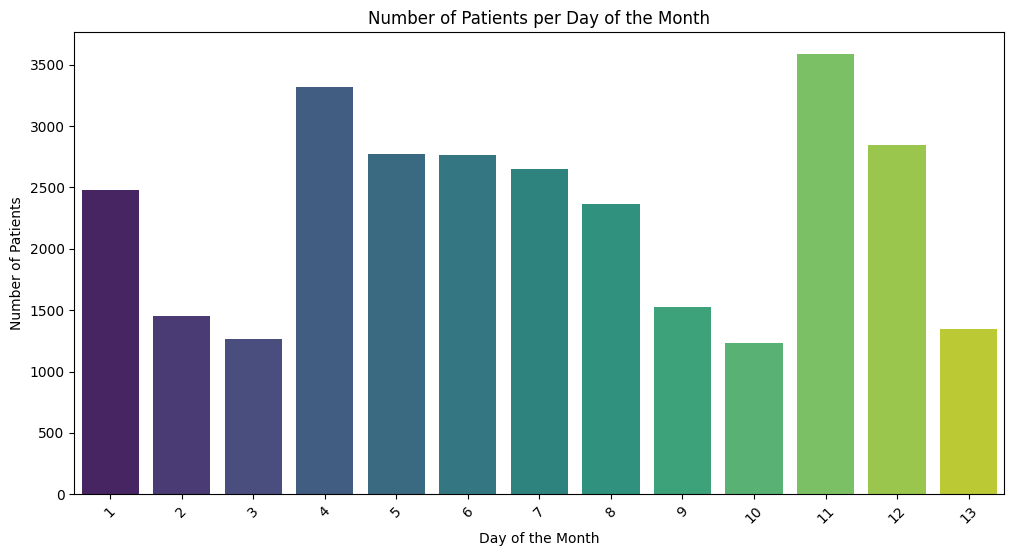

In [20]:
# Countplot of patient count in each day of the month
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Day', palette='viridis')
plt.title('Number of Patients per Day of the Month')
plt.xlabel('Day of the Month')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()

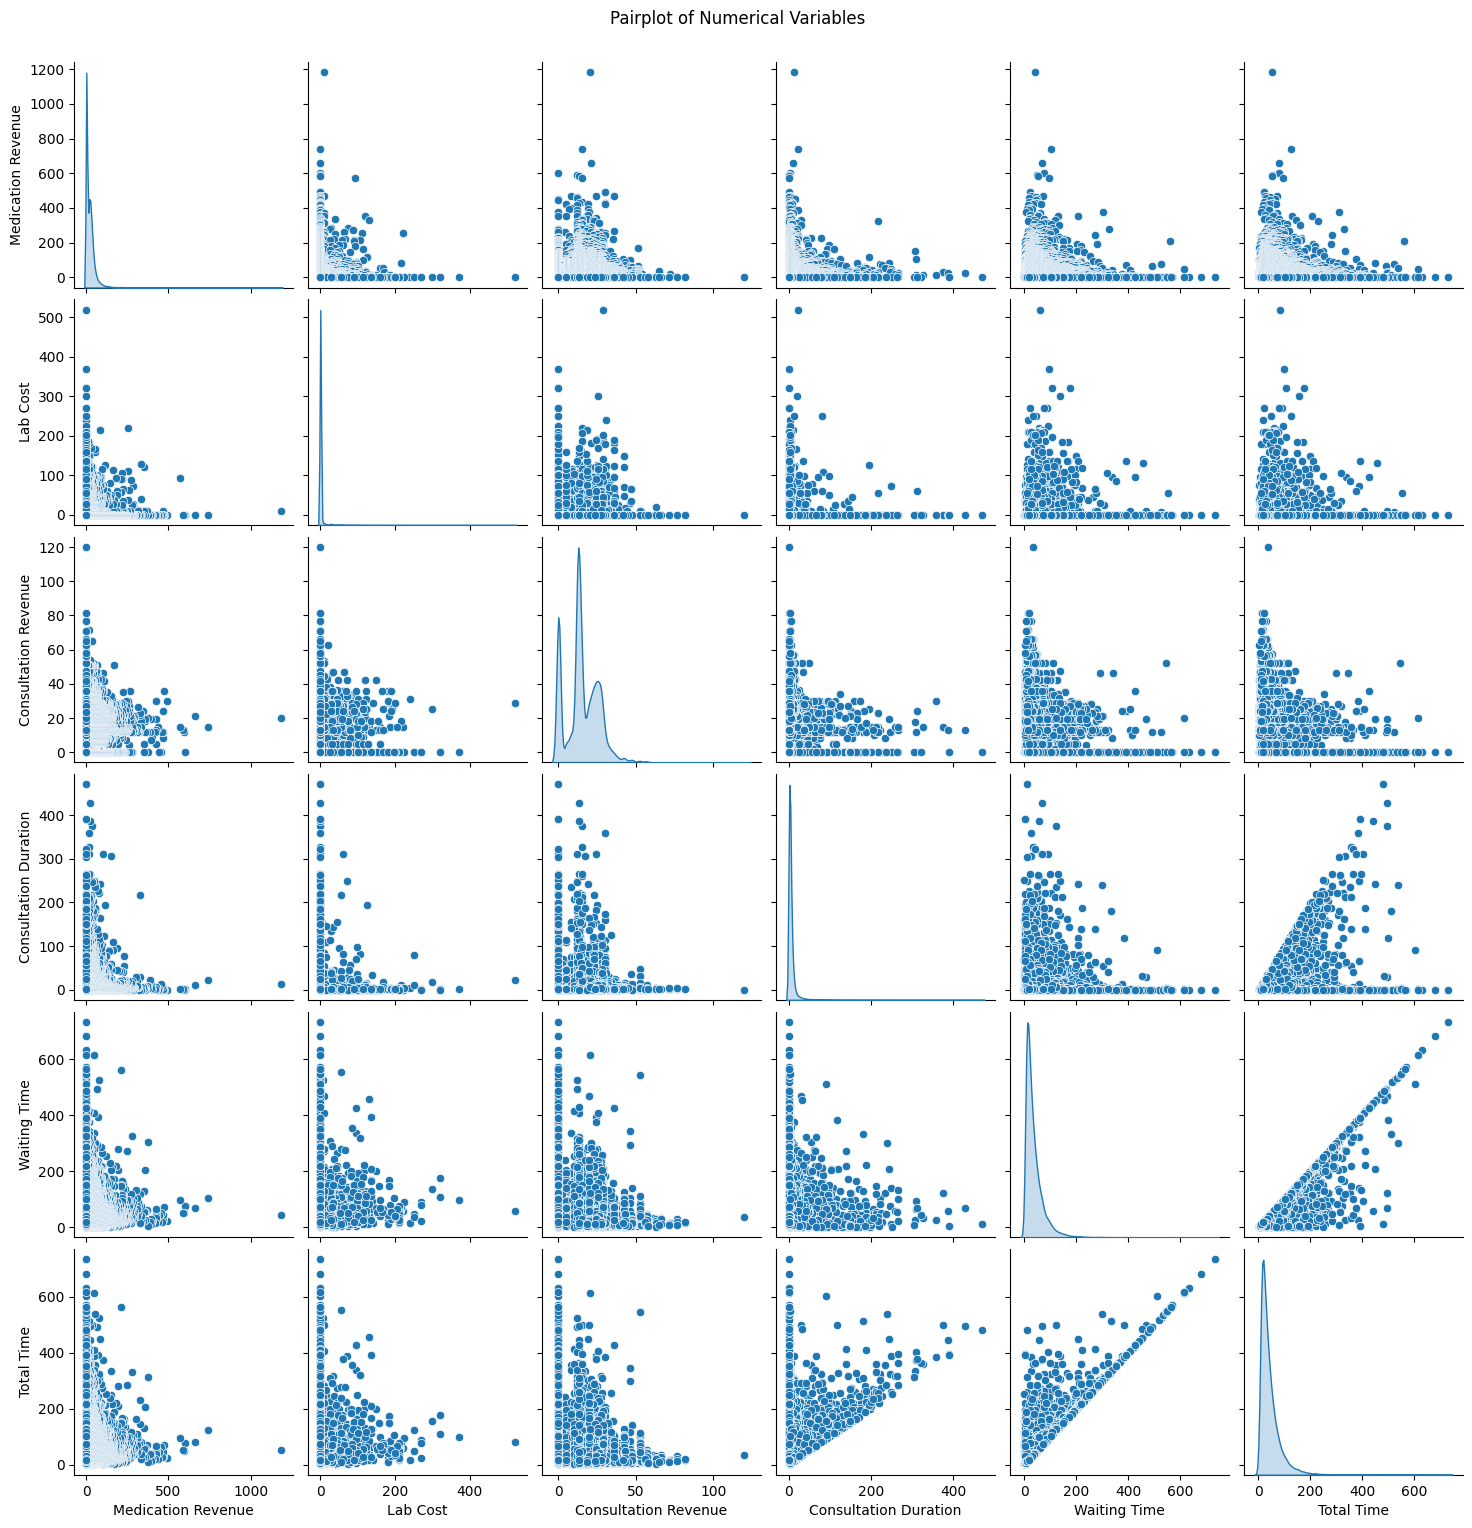

In [21]:
# Pairplot to visualize relationships between numerical variables
compare_df = df.select_dtypes(include='number').drop(columns=['Entry Time','Consultation Start Time', 'Completion Time'])
sns.pairplot(compare_df, diag_kind='kde')
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

In [22]:
df['Doctor Type'].nunique()

3

### Qn 1: Are there differences in revenue collection based on `Financial Classes`? What can be done to increase revenue for the hospital based on these differences?

Exploring `Financial Class` impact on numerical data (revenue and cost)

In [22]:
agg_methods = ['sum', 'mean']
result_dfs = {}

def create_aggregated_tables(dataframe, group_column, metrics_columns):    
    for method in agg_methods:
        # Create aggregation dictionary for the specified columns
        agg_dict = {column: method for column in metrics_columns}
        
        agg_df = dataframe.groupby(group_column).agg(agg_dict).reset_index()
        
        # Melt the dataframe to long format
        melted_df = agg_df.melt(
        id_vars=group_column,
        value_vars=metrics_columns,
        var_name='Metric Type',
        value_name=f'{method.capitalize()} Amount'
        )
        
        # Store the result
        result_dfs[method] = melted_df
    
    return result_dfs['sum'], result_dfs['mean']

metrics = ['Medication Revenue', 'Lab Cost', 'Consultation Revenue']
sum_df, mean_df = create_aggregated_tables(df, 'Financial Class', metrics)

sum_df.head()

,Financial Class,Metric Type,Sum Amount
0,CORPORATE,Medication Revenue,159277.49
1,HMO,Medication Revenue,127798.88
2,INSURANCE,Medication Revenue,303538.92
3,MEDICARE,Medication Revenue,20389.14
4,PRIVATE,Medication Revenue,0.00


In [23]:
mean_df.head()

,Financial Class,Metric Type,Mean Amount
0,CORPORATE,Medication Revenue,23.275974
1,HMO,Medication Revenue,34.841570
2,INSURANCE,Medication Revenue,30.913425
3,MEDICARE,Medication Revenue,70.065773
4,PRIVATE,Medication Revenue,0.000000


In [24]:
count_df = df.groupby("Financial Class").size().reset_index(name='Count')
count_df.head()

,Financial Class,Count
0,CORPORATE,6843
1,HMO,3668
2,INSURANCE,9819
3,MEDICARE,291
4,PRIVATE,8988


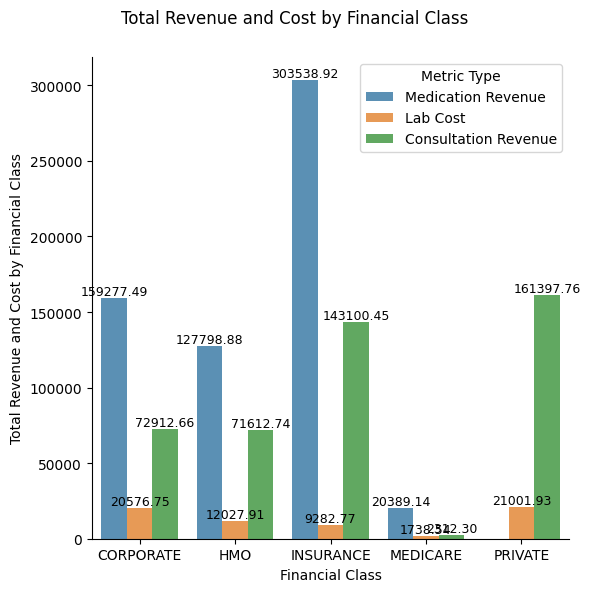

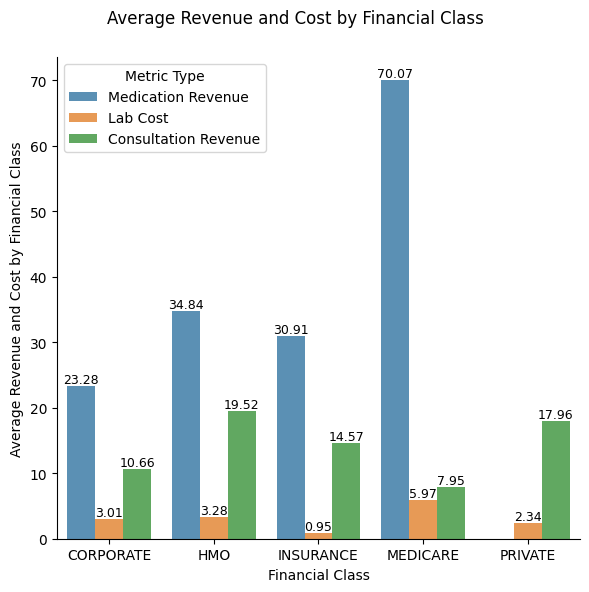

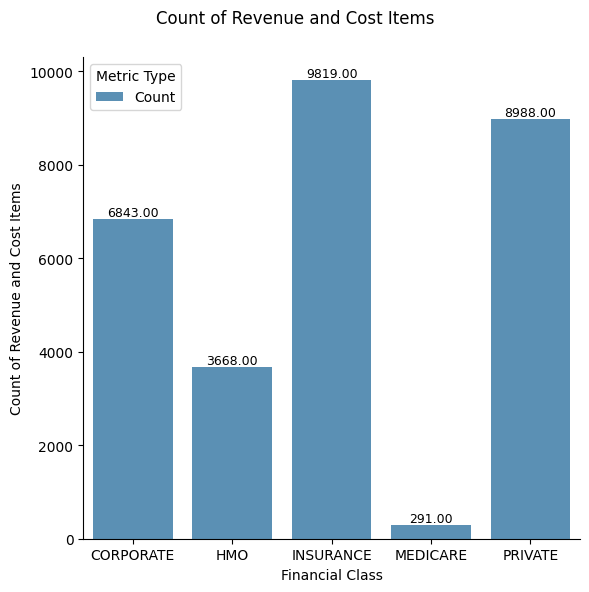

In [25]:
metrics = [
    {'y_label': 'Sum Amount', 'df': sum_df, 'title': 'Total Revenue and Cost by Financial Class', 'y_axis': 'Total Amount'},
    {'y_label': 'Mean Amount', 'df': mean_df, 'title': 'Average Revenue and Cost by Financial Class', 'y_axis': 'Mean Amount'},
    {'y_label': 'Count', 'df': count_df, 'title': 'Count of Revenue and Cost Items', 'y_axis': 'Count'}
]

plots = []

for metric in metrics:
    if metric['y_label'] == 'Count':
        metric['df']['Metric Type'] = 'Count'
    g = sns.catplot(
        data=metric['df'], kind='bar',
        x='Financial Class', y=metric['y_label'], hue='Metric Type',
        errorbar='sd', alpha=0.8, height=6, legend_out=False
    )
    
    # Add numerical labels to each bar
    for ax in g.axes.flat:
        for bar in ax.patches:
            bar_value = bar.get_height()
            if bar_value > 0:  # Only add labels for non-zero values
                ax.text(
                    bar.get_x() + bar.get_width() / 2, bar_value,
                    f'{bar_value:.2f}', ha='center', va='bottom', fontsize=9
                )

    g.set_axis_labels('Financial Class', metric['title'])
    g.figure.suptitle(metric['title'])
    g.figure.tight_layout(rect=[0, 0, 1, 0.98])

    plots.append(g)

plt.show()

In [26]:
# Finding total revenue earned per patient for each financial class

df['Total Revenue'] = df['Medication Revenue'] + df['Lab Cost'] + df['Consultation Revenue']

def calculate_total_revenue_per_patient(df):
    
    # Group by Financial Class and calculate the mean total revenue per patient
    total_revenue_per_patient = df.groupby('Financial Class')['Total Revenue'].mean().reset_index()
    
    return total_revenue_per_patient

total_revenue_per_patient = calculate_total_revenue_per_patient(df)
total_revenue_per_patient

,Financial Class,Total Revenue
0,CORPORATE,36.938024
1,HMO,57.644365
2,INSURANCE,46.432645
3,MEDICARE,83.986186
4,PRIVATE,20.293690


According to the plots above, we can see that there are indeed differences across `Financial Classes` for Total and Average Revenue.

Observation 1: Medication Revenue makes up the bulk of all revenue, with the highest contributors from Insurance, followed by Corporate, HMO and Medicare.

Observation 2: Medicare patients pay the lowest consultation fees but highest Medication fees on average

Observation 3: Most patients are under Insurance and Private Financial Classes, while only a very small percentage of patients fall under the Medicare Financial Class

Observation 4: Private patients do not pay Medication fees but pay higher consultation fees on average.

Actions:
- Enhance patient volume via outreach programmes with a focus on Medicare patients (large untapped market)
- Give discounted medication fees during campaigning period for Medicare patients which might be what is deterring more patients from visiting
- Maintain Insurance patients visitation rate by keeping fee increments to a minimal (largest customer base)
- Introduce medication fees for private patients or increase consultation and lab costs for private patients to be the highest amongst financial classes

### Qn 2. Which doctor type generates the most revenue (Medication and Consultation) per consultation?

Creating a dataframe that allows us to answer the question

In [27]:
def aggregate_doctor_revenue(df):
    """
    Aggregates revenue data for each doctor type, including mean, sum, min, max, and count.

    Parameters:
        df (pd.DataFrame): The input dataframe containing revenue data.

    Returns:
        pd.DataFrame: A dataframe with aggregated revenue metrics for each doctor type.
    """
    # Define aggregation methods
    agg_methods = {
        'Medication Revenue': ['mean', 'sum', 'min', 'max'],
        'Consultation Revenue': ['mean', 'sum', 'min', 'max']
    }

    # Perform aggregation
    agg_df = df.groupby('Doctor Type').agg(agg_methods).reset_index()

    # Flatten multi-level columns
    agg_df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in agg_df.columns]

    # Rename columns for clarity
    agg_df.rename(columns={
        'Medication Revenue mean': 'Mean Medication Revenue',
        'Consultation Revenue mean': 'Mean Consultation Revenue',
        'Medication Revenue sum': 'Sum Medication Revenue',
        'Consultation Revenue sum': 'Sum Consultation Revenue',
        'Medication Revenue min': 'Min Medication Revenue',
        'Consultation Revenue min': 'Min Consultation Revenue',
        'Medication Revenue max': 'Max Medication Revenue',
        'Consultation Revenue max': 'Max Consultation Revenue'
    }, inplace=True)

    # Add count column
    count_df = df.groupby('Doctor Type').size().reset_index(name='Count')
    agg_df = pd.merge(agg_df, count_df, on='Doctor Type')

    return agg_df

# Call the function
doc_df = aggregate_doctor_revenue(df)
doc_df

,Doctor Type,Mean Medication Revenue,Sum Medication Revenue,Min Medication Revenue,Max Medication Revenue,Mean Consultation Revenue,Sum Consultation Revenue,Min Consultation Revenue,Max Consultation Revenue,Count
0,ANCHOR,21.234703,460814.30,0.0,1183.22,14.479309,314215.49,0.0,71.03,21701
1,FLOATING,19.167822,24381.47,0.0,493.85,15.553145,19783.60,0.0,120.00,1272
2,LOCUM,18.958508,125808.66,0.0,586.80,17.681860,117336.82,0.0,81.31,6636


From the above `doc_df`, we can see that the mean `Medication Revenue` brought in by Anchor doctors are the highest at $21.3, with Floating and Locum doctors have similar mean `Medication Revenue` of $18.9.

We can also see that the mean `Consultation Revenue` brought in by Locum doctors are the highest at $17.7, with Anchor and Floating doctors having mean of $14.5 and $15.6 respectively.

Therefore Anchor doctors generate the most `Medication Revenue` per consultation and Locum doctors generate the most `Consultation Revenue` per consultation.

As such, to increase revenue, the hospital should prioritise bringing in more Anchor and Locum doctors instead of Floating doctors.

Upon further inspection, it can also be seen that the maximum medication revenue for one consultation is much higher than that for consultation. This might suggest that the variance of each patients' payable `Medication Revenue` is much higher than that of `Consultation Revenue`. A boxplot distribution is drawn to visualise the differences.

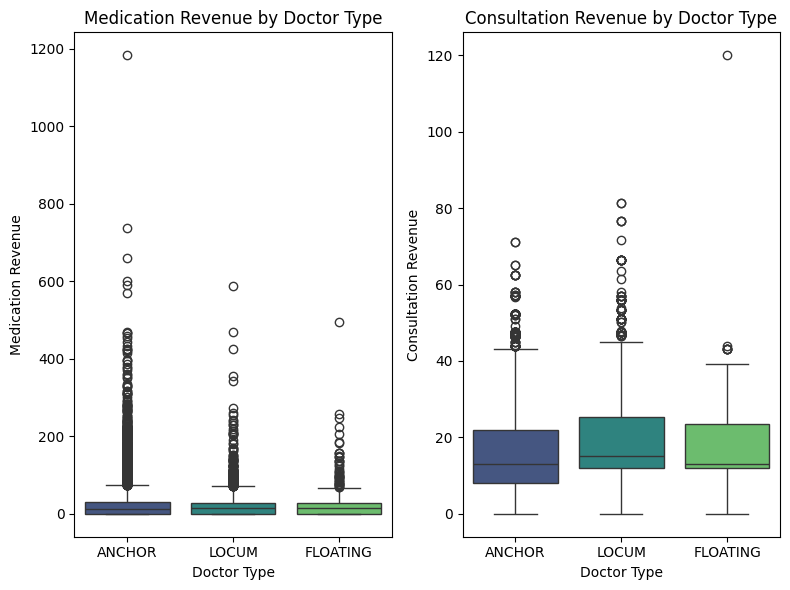

In [28]:
# Plot histogram of medication revenue and consultation revenue by doctor type
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

revenue = ['Medication Revenue', 'Consultation Revenue']
for i, rev in enumerate(revenue):
    sns.boxplot(data=df, x='Doctor Type', y=rev, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{rev} by Doctor Type')
    axes[i].set_xlabel('Doctor Type')
    axes[i].set_ylabel(rev)

plt.tight_layout()
plt.show()

This confirms that the spread of data points is higher  and there are many more outliers with greater values for `Medication Revenue` than `Consultation Revenue`.

As such, if the hospital was constrained (by budget or time) to focus on bringing in only 1 type of doctor, Anchor doctors would be the most viable option.

### Qn 3. Determine busy periods that require more manpower and make any improvements or suggestions with reference to insights gathered from the analysis.

Create a new dataframe to visualise busy periods using heatmaps: 1 for count of patients in each Hour of each Day and 1 for waiting time in each Hour of each Day

In [29]:
# Create a dataframe for Days of the Week as columns and Hours as rows with their respective counts for each Day-Hour pair
day_hour_counts = df.groupby(['Hours','Day Of Week']).size().unstack(fill_value=0)
day_hour_counts = day_hour_counts.reindex(columns=day_order, fill_value=0)

# Create a dataframe for Days of the Week as columns and Hours as rows with their respective waiting time in the hospital for each Day-Hour pair
day_hour_waiting_time = df.groupby(['Hours', 'Day Of Week'])['Waiting Time'].mean().unstack()
day_hour_waiting_time.fillna(0, inplace=True)
day_hour_waiting_time = day_hour_waiting_time.reindex(columns=day_order, fill_value=0).round(2)

day_hour_counts

Day Of Week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Hours,,,,,,,
7,0,4,5,1,0,1,1
8,754,622,541,293,538,416,266
9,922,727,699,353,597,557,393
10,769,571,635,240,502,517,407
11,642,541,494,250,528,429,385
12,268,234,234,107,222,186,182
13,100,76,66,30,68,30,54
14,822,680,378,284,586,137,108
15,481,391,200,181,372,99,94


In [30]:
day_hour_waiting_time

Day Of Week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Hours,,,,,,,
7,0.00,38.00,45.26,21.63,0.00,32.58,8.70
8,47.08,47.13,42.53,45.20,45.04,50.16,32.61
9,58.21,50.68,52.07,52.48,53.67,51.90,33.77
10,54.52,42.38,48.60,44.07,48.30,43.66,28.13
11,43.88,31.64,38.36,33.37,36.69,32.00,26.22
12,29.71,27.44,35.83,32.60,34.52,22.03,24.70
13,43.92,22.67,36.31,41.61,39.77,42.16,40.38
14,41.23,36.78,34.24,35.64,34.61,30.01,28.15
15,37.20,33.48,35.84,30.85,30.82,29.36,21.75


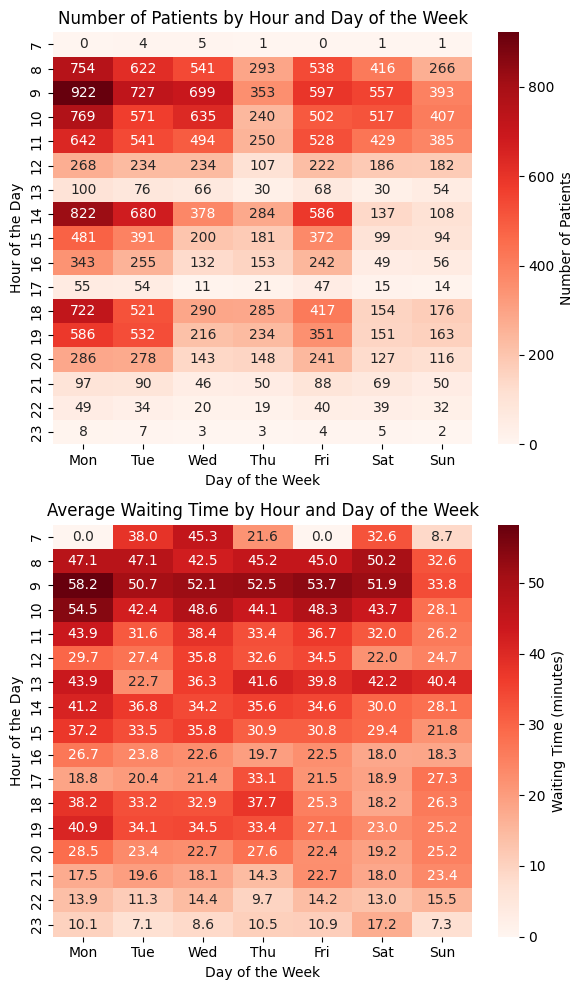

In [31]:
fig = plt.figure(figsize=(6, 10))

plt.subplot(2,1,1)
sns.heatmap(day_hour_counts, cmap='Reds', annot=True, fmt='d', cbar_kws={'label': 'Number of Patients'})
plt.title('Number of Patients by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

plt.subplot(2,1,2)
sns.heatmap(day_hour_waiting_time, cmap='Reds', annot=True, fmt='.1f', cbar_kws={'label': 'Waiting Time (minutes)'})
plt.title('Average Waiting Time by Hour and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day')

plt.tight_layout()
plt.show()

As can be seen from the graphs above, the hospital is the busiest on Mondays at 9am. In general, the busiest period is from 9 to 11am across all days, with Monday being the busiest day of the week. Additionally, the periods from 2-4pm and 6-8pm also see a spike in patients. Intuitively, the average waiting time for patients are higher when there are more patients present. A pairplot is graphed to confirm this phenomenon.

<Figure size 1000x600 with 0 Axes>

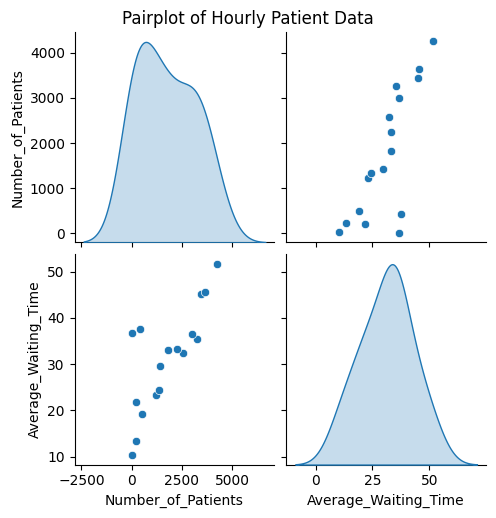

In [32]:
# Create dataframe grouped by hour with 2 columns number of patients and average waiting time
hourly_waiting_time = df.reset_index()
hourly_waiting_time = hourly_waiting_time.groupby('Hours').agg(
    Number_of_Patients=('Patient ID', 'count'),
    Average_Waiting_Time=('Waiting Time', 'mean')
).reset_index().round(2).set_index('Hours')

plt.figure(figsize=(10, 6))
sns.pairplot(hourly_waiting_time, diag_kind='kde', palette='viridis')
plt.suptitle('Pairplot of Hourly Patient Data', y=1.02)
plt.show()

However, it is important to note that for periods with less patients such at at 1pm and 5pm, there seems to still be a relatively high average wait time. Thus, in order to reduce the load on the hospital staff, as well as reduce waiting time for patients, more consideration can be given to account for busy periods as stated above.

As such, more staff are needed on mornings at 9am, as well as on Mondays.

The following section will cover some suggestions that could be implemented to improve the overall administrative matters of the hopsital

## Suggestions and Improvements

1. Introduce pre-appointment scheduling via a mobile application
    - Enables patients to take a queue number and wait at home, increasing convenience and reduce physical waiting time
2. Increase staff availability at 8am, 2-4pm and 6-8pm
    - To handle increased number of patients at these hours.
3. Reschedule staff from Saturdays after 4pm to Mondays from 8am
    - Better allocation of human resources
    - This is in assumption that those working on Sat after 4pm are not already working on Monday mornings.
4. Implement staggered and reduced meal breaks for staff
    - To bring down average wait time even at 1pm and 5pm where there are less patients 
5. Change appointment opening hour to 8am
    - Since number of patients who come at 7am is negligible

In [33]:
df

,Day Of Week,Day,Hours,Medication Revenue,Lab Cost,Consultation Revenue,Doctor Type,Financial Class,Entry Time,Consultation Start Time,Completion Time,Consultation Duration,Waiting Time,Total Time,Total Revenue
Patient ID,,,,,,,,,,,,,,,
C10001,Mon,4,8,1183.22,10.0,20.17,ANCHOR,HMO,0 days 08:35:45,0 days 09:17:54,0 days 09:29:46,11.866667,42.150000,54.016667,1213.39
C10002,Wed,6,19,738.48,0.0,15.00,ANCHOR,INSURANCE,0 days 19:19:16,0 days 21:02:36,0 days 21:24:07,21.516667,103.333333,124.850000,753.48
C10003,Sat,2,10,660.00,0.0,21.17,ANCHOR,HMO,0 days 10:46:52,0 days 11:56:25,0 days 12:06:28,10.050000,69.550000,79.600000,681.17
C10004,Wed,6,9,600.00,0.0,0.00,ANCHOR,MEDICARE,0 days 09:38:34,0 days 10:55:50,0 days 10:58:02,2.200000,77.266667,79.466667,600.00
C10005,Fri,1,11,591.60,0.0,12.00,ANCHOR,INSURANCE,0 days 11:16:21,0 days 12:06:49,0 days 12:06:54,0.083333,50.466667,50.550000,603.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C39995,Wed,13,14,0.00,0.0,0.00,ANCHOR,PRIVATE,0 days 14:01:24,0 days 14:08:56,0 days 14:15:42,6.766667,7.533333,14.300000,0.00
C39996,Wed,13,14,0.00,0.0,0.00,ANCHOR,PRIVATE,0 days 14:01:33,0 days 14:21:17,0 days 14:21:53,0.600000,19.733333,20.333333,0.00
C39997,Wed,13,14,0.00,0.0,0.00,ANCHOR,PRIVATE,0 days 14:01:41,0 days 14:13:57,0 days 14:16:29,2.533333,12.266667,14.800000,0.00


In [34]:
#df.to_csv('hospital_data_cleaned.csv')

## Prediction of Revenue

In this segment, I will attempt to predict `Total Revenue` using Random Forest Regression.

Reasons for choosing Random Forest:
1. Handles Non-Linearity
2. Suitable for large datasets with 10k+ rows
2. No Need to Scale Features

In [35]:
from scipy.special import inv_boxcox
from scipy.stats import boxcox

# Select relevant columns
features = ['Day Of Week', 'Hours', 'Consultation Duration', 'Waiting Time',
            'Total Time', 'Doctor Type', 'Financial Class']
target = 'Total Revenue'

# Encode Day of Week (Mon-Sun to 1-7)
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_mapping = {day: idx+1 for idx, day in enumerate(day_order)}
df['Day Of Week'] = df['Day Of Week'].map(day_mapping)

# Convert 'Hours' to category
df['Hours'] = df['Hours'].astype('category')

# Label encode 'Doctor Type' and 'Financial Class'
df['Doctor Type'] = LabelEncoder().fit_transform(df['Doctor Type'])
df['Financial Class'] = LabelEncoder().fit_transform(df['Financial Class'])

# Handle skewness with boxcox
df['Consultation Duration'], lmbda = boxcox(df['Consultation Duration'])

# Handle skewness with log1p
df['Waiting Time'] = np.log1p(df['Waiting Time'])
df['Total Time'] = np.log1p(df['Total Time'])
df['Total Revenue'] = np.log1p(df['Total Revenue'])

# Split data
X = df[['Day Of Week', 'Hours', 'Consultation Duration', 'Waiting Time', 'Total Time', 'Doctor Type', 'Financial Class']]
y = df['Total Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

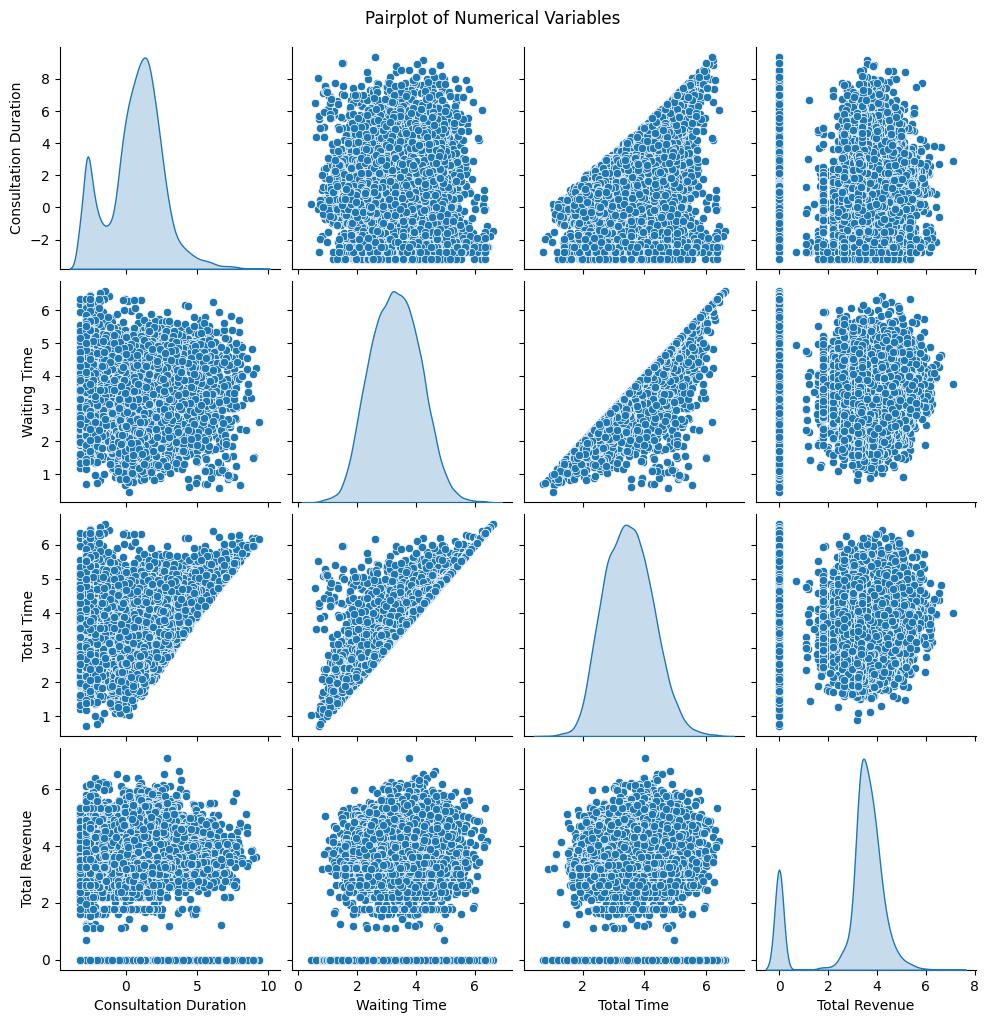

In [36]:
# Pairplot to visualize relationships between numerical variables
transform_results = df[['Consultation Duration', 'Waiting Time', 'Total Time', 'Total Revenue']]
sns.pairplot(transform_results, diag_kind='kde')
plt.suptitle('Pairplot of Numerical Variables', y=1.02)
plt.show()

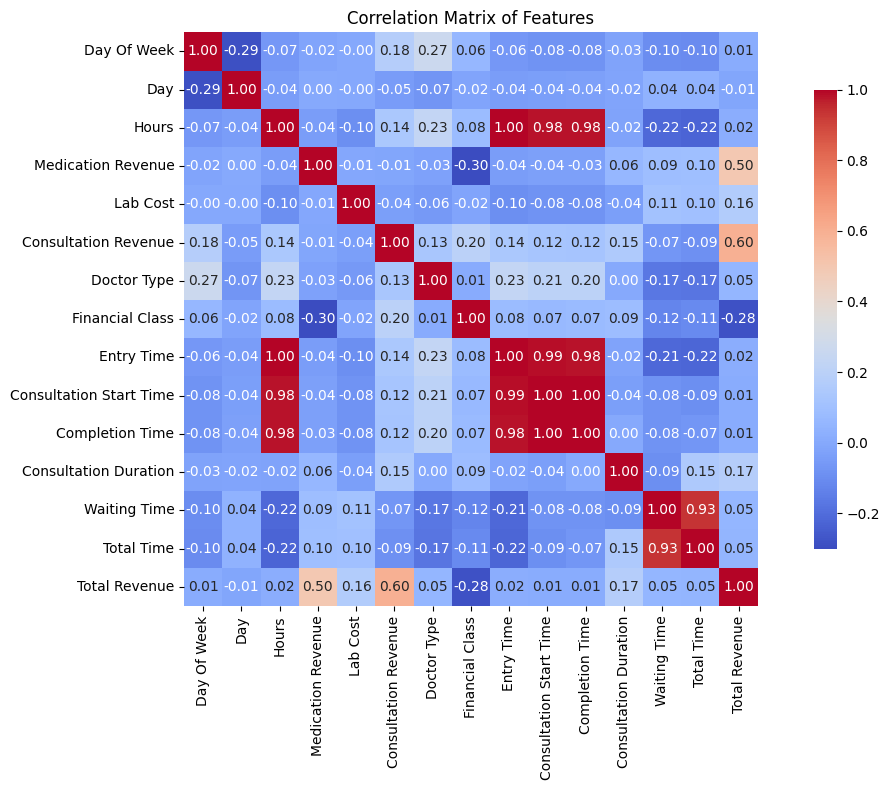

In [37]:
# Correlation matrix to visualise relationships
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()

In [117]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}
model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluation
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)

best_params = grid.best_params_
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'Best Params: {best_params}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [ ]:
# Visualise actual vs predicted values after reversing the transformations
# Total Revenue was log-transformed so we need to reverse it
prediction_df = pd.DataFrame({'Actual': np.expm1(y_test),
                              'Predicted': np.expm1(y_pred)})
prediction_df

,Actual,Predicted
Patient ID,,
C30758,0.00,11.059522
C11694,81.44,27.774414
C29585,32.72,14.975232
C16250,54.79,47.557409
C11482,78.04,31.691082
...,...,...
C27669,18.10,39.781090
C21740,42.31,36.366650
C24987,26.60,40.068879


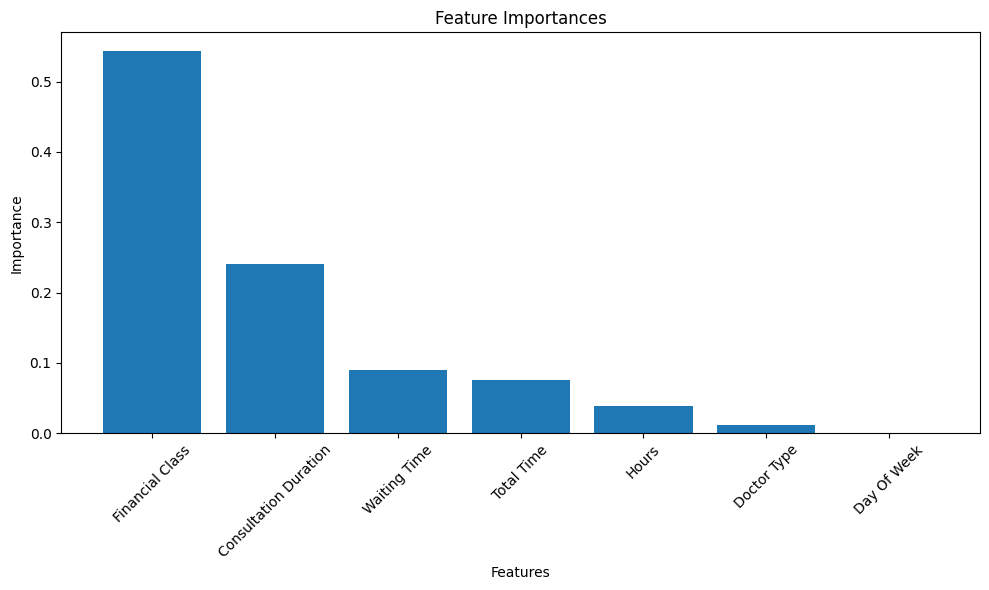

In [ ]:
# Plotting feature importances
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()